#### Setting Up

In [ ]:
import pandas as pd
import numpy as np
import sklearn 
import sklearn.datasets
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/smoteNCTrain.csv')
df_test = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/smoteNCTest.csv')

In [ ]:
df_train.shape

(50164, 15)

In [ ]:
df_test.shape

(21518, 15)

In [ ]:
X_train = df_train.iloc[:,1:-1] # all the variables
y_train = df_train.iloc[:,-1] # labels

X_test = df_test.iloc[:,1:-1] # all the variables
y_test = df_test.iloc[:,-1] # labels

In [ ]:
### Helper method

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#### Logistic Regression (without scaling)

--------LR-------
10719
Accuracy Score is 0.49814
Recall Score is 0.34241
Precision Score is 0.4973
F1 Score is 0.40557
      0     1
0  7035  3724
1  7075  3684
[[0.65387118 0.34612882]
 [0.657589   0.342411  ]]


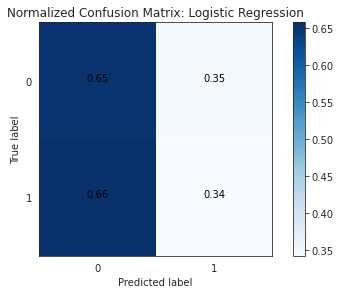

In [ ]:
print("--------LR-------")
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=100,random_state=42)
model.fit(X_train, y_train)


y_predict = model.predict(X_test)
print(sum(y_predict == y_test))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict))) # very bad recall...
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))

print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

##### Bias-Variance Trade-off Plot

In [ ]:
# Let's plot the bias variance plot to see 
import sklearn
import autograd.numpy as grad_np

n_iterations = 100 # Number of iterations used to calculate the average losses, set this high to have smooth plot
max_points = 200
 # Number of points in the training set, set this high to extend x-axis

training_losses = grad_np.zeros(max_points)
expected_losses = grad_np.zeros(max_points)
eps = 1e-10


# Using:
# X_train
# y_train
# X_test
# y_test


for num_points in range(10, max_points+1):
  
    training_loss = 0.0
    expected_loss = 0.0

    for i in range(n_iterations):
        # generate random samples for training
        sample_x = X_train.sample(num_points)
        sample_y = y_train[sample_x.index]

        model = LogisticRegression()
        model.fit(sample_x, sample_y)

        training_loss += sklearn.metrics.log_loss(y_true = sample_y, y_pred = np.clip(model.predict_proba(sample_x),eps,1-eps))
        expected_loss += sklearn.metrics.log_loss(y_true = y_test, y_pred = np.clip(model.predict_proba(X_test),eps,1-eps))
    training_losses[num_points - 1] = training_loss / n_iterations
    expected_losses[num_points - 1] = expected_loss / n_iterations

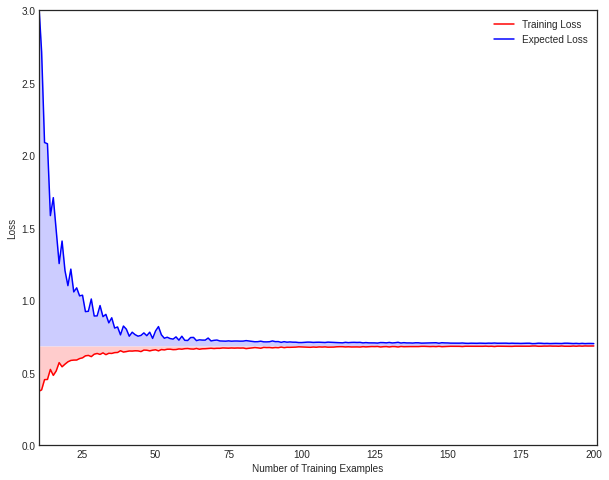

In [ ]:
fig, ax = plt.subplots()

plt.style.use('seaborn-white')
plt.xlim(10, max_points + 1)
plt.ylim(0, 3)
plt.xlabel('Number of Training Examples')
plt.ylabel('Loss')
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(range(1, max_points + 1), training_losses, 'r', label='Training Loss')
plt.plot(range(1, max_points + 1), expected_losses, 'b', label='Expected Loss')
ax.fill_between(range(1, max_points + 1), 0.685, expected_losses, facecolor='blue', alpha=0.2)
ax.fill_between(range(1, max_points + 1), 0.685, training_losses, facecolor='red', alpha=0.2)
plt.legend()
plt.show()
#training_losses

##### ROC curve

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.481


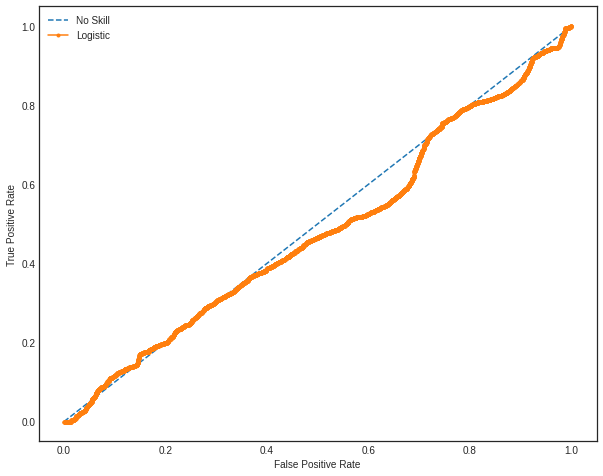

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

model = LogisticRegression()
model.fit(X_train, y_train)

# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


It seems logistic regression performs very badly on this dataset. We suspect that this is because the data are not linearly seperable.
Now we shall investigate using random forest and decision tree based models.

#### Decision Tree

--------Decision Tree--------
15585
Accuracy Score is 0.72428
Recall Score is 0.47161
Precision Score is 0.9534
F1 Score is 0.63106
       0     1
0  10511   248
1   5685  5074
[[0.97694953 0.02305047]
 [0.52839483 0.47160517]]


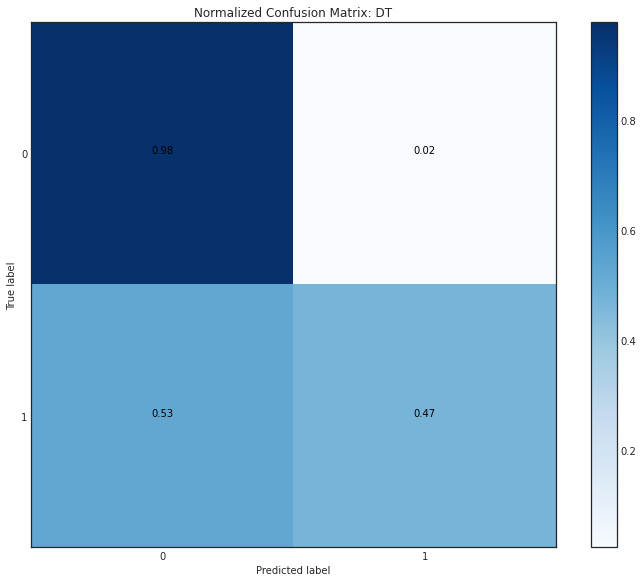

In [ ]:
print("--------Decision Tree--------")
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = 42,)

model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(sum(y_predict == y_test))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: DT')

In [ ]:
# Let's plot the bias variance plot to see 
import sklearn
import autograd.numpy as grad_np

n_iterations = 30 # Number of iterations used to calculate the average losses
max_points = 1000 # Number of points in the training set

training_losses = grad_np.zeros(max_points)
expected_losses = grad_np.zeros(max_points)
eps = 1e-10
#X_sample = X.sample(10)
#y_sample = y[X_sample.index]

# Using:
# X_train_underbalanced
# y_train_underbalanced
# X_test_underbalanced
# y_test_underbalanced


for num_points in range(10, max_points+1):
  
    training_loss = 0.0
    expected_loss = 0.0

    for i in range(n_iterations):
        # generate random samples for training
        sample_x = X_train.sample(num_points)
        sample_y = y_train[sample_x.index]

        model = model=DecisionTreeClassifier(random_state=42, 
  min_samples_leaf= 1, 
  min_samples_split= 2,
  max_depth= 35, 
  criterion= "entropy" )
        model.fit(sample_x, sample_y)

        training_loss += sklearn.metrics.log_loss(y_true = sample_y, y_pred = np.clip(model.predict(sample_x),eps,1-eps))
        expected_loss += sklearn.metrics.log_loss(y_true = y_test, y_pred = np.clip(model.predict(X_test),eps,1-eps))
    training_losses[num_points - 1] = training_loss / n_iterations
    expected_losses[num_points - 1] = expected_loss / n_iterations

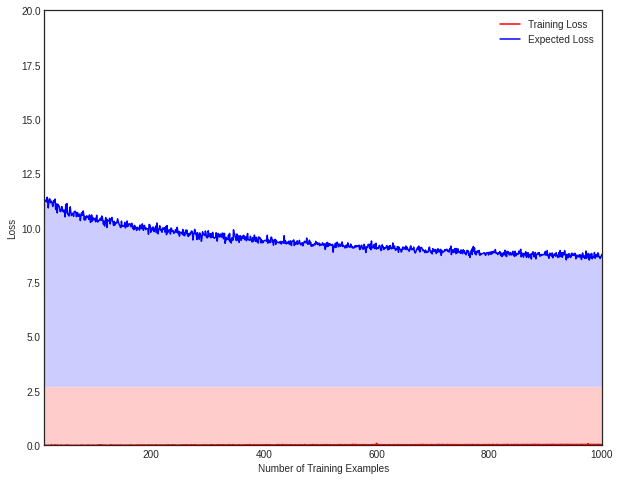

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000008e-10, 1.00000008e-10, 1.00000008e-10,
       1.00000008e-10, 1.00000008e-10, 1.00000008e-10, 1.00000008e-10,
       1.00000008e-10, 1.00000008e-10, 1.00000008e-10, 1.00000008e-10,
       1.00000008e-10, 1.00000008e-10, 3.33707985e-02, 1.00000008e-10,
       1.00000008e-10, 1.00000008e-10, 1.00000008e-10, 1.00000008e-10,
       2.64664954e-02, 1.00000008e-10, 1.00000008e-10, 1.00000008e-10,
       2.32584354e-02, 1.00000008e-10, 1.00000008e-10, 1.00000008e-10,
       1.00000008e-10, 1.00000008e-10, 1.00000008e-10, 1.91882092e-02,
       1.00000008e-10, 1.00000008e-10, 1.00000008e-10, 1.00000008e-10,
       1.00000008e-10, 1.00000008e-10, 1.00000008e-10, 1.59901744e-02,
       1.56638443e-02, 1.00000008e-10, 1.00000008e-10, 1.47601610e-02,
       1.44816674e-02, 1.00000008e-10, 1.00000008e-10, 1.00000008e-10,
      

In [ ]:
fig, ax = plt.subplots()

plt.style.use('seaborn-white')
plt.xlim(10, max_points + 1)
plt.ylim(0, 20)
plt.xlabel('Number of Training Examples')
plt.ylabel('Loss')
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(range(1, max_points + 1), training_losses, 'r', label='Training Loss')
plt.plot(range(1, max_points + 1), expected_losses, 'b', label='Expected Loss')
ax.fill_between(range(1, max_points + 1), 2.7, expected_losses, facecolor='blue', alpha=0.2)
ax.fill_between(range(1, max_points + 1), 2.7, training_losses, facecolor='red', alpha=0.2)
plt.legend()
plt.show()
training_losses

#### Random Forest

--------RF--------
14677
Accuracy Score is 0.68208
Recall Score is 0.37754
Precision Score is 0.96576
F1 Score is 0.54287
       0     1
0  10615   144
1   6697  4062
[[0.98661586 0.01338414]
 [0.62245562 0.37754438]]


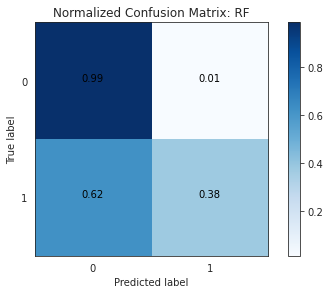

In [ ]:
print("--------RF--------")
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)


y_predict = model.predict(X_test)
print(sum(y_predict == y_test))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: RF')

#### LightGBM

--------LGBM--------


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 5, 6, 7, 8, 11, 12, 13]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


16712
Accuracy Score is 0.77665
Recall Score is 0.63696
Precision Score is 0.88392
F1 Score is 0.74038
      0     1
0  9859   900
1  3906  6853
[[0.9163491  0.0836509 ]
 [0.36304489 0.63695511]]


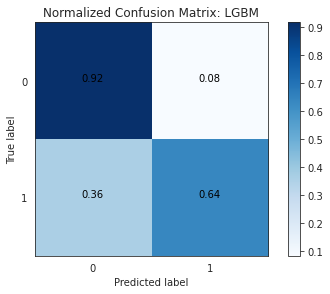

In [ ]:
print("--------LGBM--------")
import lightgbm as lgb
model = lgb.LGBMClassifier(random_state = 42)
model.fit(X_train, y_train)


y_predict = model.predict(X_test)
print(sum(y_predict == y_test))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: LGBM')

In [ ]:
# Let's plot the bias variance plot to see 
import sklearn
import autograd.numpy as grad_np

n_iterations = 30 # Number of iterations used to calculate the average losses
max_points = 200 # Number of points in the training set

training_losses = grad_np.zeros(max_points)
expected_losses = grad_np.zeros(max_points)
eps = 1e-10
#X_sample = X.sample(10)
#y_sample = y[X_sample.index]

# Using:
# X_train_underbalanced
# y_train_underbalanced
# X_test_underbalanced
# y_test_underbalanced


for num_points in range(10, max_points+1):
  
    training_loss = 0.0
    expected_loss = 0.0

    for i in range(n_iterations):
        # generate random samples for training
        sample_x = X_train.sample(num_points)
        sample_y = y_train[sample_x.index]

        model = lgb.LGBMClassifier(random_state = 42)
        model.fit(sample_x, sample_y)

        training_loss += sklearn.metrics.log_loss(y_true = sample_y, y_pred = np.clip(model.predict_proba(sample_x),eps,1-eps))
        expected_loss += sklearn.metrics.log_loss(y_true = y_test, y_pred = np.clip(model.predict_proba(X_test),eps,1-eps))
    training_losses[num_points - 1] = training_loss / n_iterations
    expected_losses[num_points - 1] = expected_loss / n_iterations

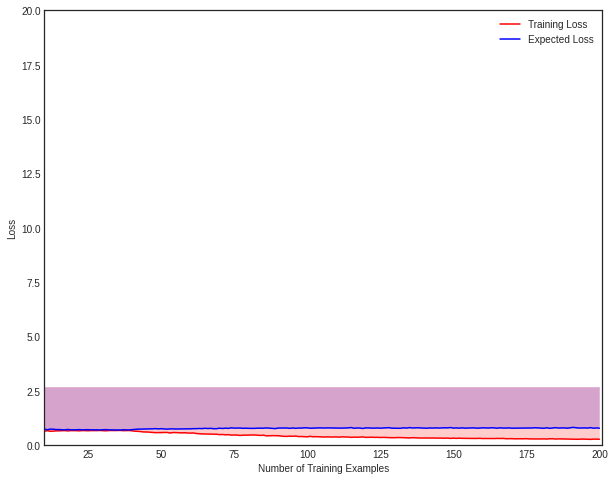

In [ ]:
fig, ax = plt.subplots()

plt.style.use('seaborn-white')
plt.xlim(10, max_points + 1)
plt.ylim(0, 20)
plt.xlabel('Number of Training Examples')
plt.ylabel('Loss')
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(range(1, max_points + 1), training_losses, 'r', label='Training Loss')
plt.plot(range(1, max_points + 1), expected_losses, 'b', label='Expected Loss')
ax.fill_between(range(1, max_points + 1), 2.7, expected_losses, facecolor='blue', alpha=0.2)
ax.fill_between(range(1, max_points + 1), 2.7, training_losses, facecolor='red', alpha=0.2)
plt.legend()
plt.show()


#### SVM test

In [ ]:
from sklearn.svm import SVC
clf_svm = SVC(random_state=42,kernel='linear')
clf_svm.fit(X_train.iloc, y_train.iloc)


SVC(kernel='linear', random_state=42)

In [ ]:
# baseline SVM
# takes very long to run
y_predict = clf_svm.predict(X_test)
print(sum(y_predict == y_test))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: SVM')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
# accuracy = 0.511


In [ ]:
# didnt help much
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}



clf_svm = SVC(random_state=42,C=10,kernel='rbf')
clf_svm.fit(X_train, y_train)
y_predict = clf_svm.predict(X_test)
print(sum(y_predict == y_test))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: SVM')

#### TSNE Plot

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50164 samples in 0.111s...
[t-SNE] Computed neighbors for 50164 samples in 2.645s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50164
[t-SNE] Computed conditional probabilities for sample 2000 / 50164
[t-SNE] Computed conditional probabilities for sample 3000 / 50164
[t-SNE] Computed conditional probabilities for sample 4000 / 50164
[t-SNE] Computed conditional probabilities for sample 5000 / 50164
[t-SNE] Computed conditional probabilities for sample 6000 / 50164
[t-SNE] Computed conditional probabilities for sample 7000 / 50164
[t-SNE] Computed conditional probabilities for sample 8000 / 50164
[t-SNE] Computed conditional probabilities for sample 9000 / 50164
[t-SNE] Computed conditional probabilities for sample 10000 / 50164
[t-SNE] Computed conditional probabilities for sample 11000 / 50164
[t-SNE] Computed conditional probabilities for sample 12000 / 50164
[t-SNE] Computed conditional probabilities for sam

[Text(0.5, 1.0, 'Iris data T-SNE projection')]

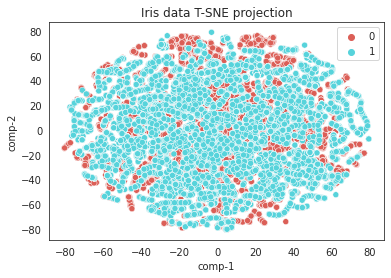

In [ ]:
# TSNE
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd  

x = X_train
y = y_train
tsne = TSNE(n_components=2, verbose=1, random_state=42)
z = tsne.fit_transform(x) 

df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="T-SNE projection") 

#### Last Note: Considerations on Evaulation Metircs:

In our dataset, we label a 'bad customer' as positive (1) and a 'good customer' as negative (0).

Across all notebooks, we will be implementing four evaualtion metrics. This is for us to have a guage on the model performance, regardless of real-world considerations. 


1. Accuracy
2. Recall
3. Precision
4. F1 Score

In addition, we are able to use a normalised confusion matrix, as our testing set has a class balance, thus allowing us to use the normalised values, since the number of both classes are similar

In general, however, we choose to focus on not only recall, but it's overall accuracy. Compared to loans, money drawn from credit cards are generally  of less amount, and are repaid faster. The parties involved in the credit card business profit from the credit card business from both the interest charged from overdue balances, as well as transaction fee charged as a percentage of the purchases made. 

Therefore, in evaulating the effectiveness of a credit card approval ML model, one must consider the recall of the model, so that the banks can reduce the considerable amount of losses incurred from defaulted credit cards, by identifiying the 'bad' customers. Furthermore, it is perhaps equally important that enough card are issued to the 'good' customers, so that the profitability of the banks and card issuers are maintained. As such, we consider both recall and accuracy in the evaulation of our model.